In [27]:
import json
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Open and read the JSON file
with open('TP53_mutation_labels.json', 'r') as file:
    data = json.load(file)

rows = []
for key, values in data.items():
    for value in values:
        rows.append({'category': key, 'name': value})

df_mut_label = pd.DataFrame(rows)


In [3]:
import pickle

with open('all_mut_layer_33_pos_mean.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
df = pd.merge(df_mut_label, data, how = "left", on = "name")

In [5]:
with open('all_mut_layer_33_diff.pkl', 'rb') as f:
    data = pickle.load(f)

df = pd.merge(df, data, how = "left", on = "name")

In [6]:
df["Pos"] = df["name"].str[1:-1].astype(int)

In [7]:
## contains some ambiguous amino acids such as B or Z, let's ignore for now
last_chars = set(df[df["embedding_mean"].isna()]["name"].str[-1])

In [8]:
df[df["embedding_mean"].isna()]

,category,name,embedding_mean,embedding_diff,Pos
293,DN & LoF,T170Z,NaN,NaN,170
818,Only DN,Q136B,NaN,NaN,136
894,Only DN,E180B,NaN,NaN,180
1057,Only DN,D281B,NaN,NaN,281
1076,Only DN,L383Z,NaN,NaN,383
...,...,...,...,...,...
7803,Others,Z394S,NaN,NaN,394
7804,Others,Z394T,NaN,NaN,394
7805,Others,Z394V,NaN,NaN,394
7806,Others,Z394W,NaN,NaN,394


In [9]:
df = df[~df["embedding_mean"].isna()]

In [10]:
df.value_counts("category")

category
Others      5387
DN & LoF     777
Only LoF     540
Only DN      295
Name: count, dtype: int64

In [11]:
# df = df[df['category'].isin(['Only LoF', 'Only DN'])]
# df.value_counts("category")

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['category'], 
    random_state=42
)

# difference-in-means

In [13]:
train_df.value_counts("category")

category
Others      4309
DN & LoF     622
Only LoF     432
Only DN      236
Name: count, dtype: int64

## mean over residue is not really informative

In [14]:
# Then, group by category
grouped = train_df.groupby('category')['embedding_mean'].apply(list)

# Compute mean tensor for each group
mean_embeddings = {}
for category, tensors in grouped.items():
    print(category)
    stacked = torch.stack(tensors)  # shape: (num_samples, embedding_dim)
    print(stacked.shape)
    mean = stacked.mean(dim=0)      # shape: (embedding_dim,)
    mean_embeddings[category] = mean

# Now, calculate difference
difference_vector = mean_embeddings['Only LoF'] - mean_embeddings['Only DN']

print(difference_vector)

DN & LoF
torch.Size([622, 1280])
Only DN
torch.Size([236, 1280])
Only LoF
torch.Size([432, 1280])
Others
torch.Size([4309, 1280])
tensor([-0.0005, -0.0007, -0.0007,  ..., -0.0002, -0.0005, -0.0009])


In [15]:
## difference in means doesn't seem to work, at least when using the mean activation over residues

difference_vector.max()

tensor(0.0072)

In [16]:
mean_embeddings["Only LoF"].max()

tensor(2.4634)

## let's look at activation diff for the specific residue

In [17]:
# Then, group by category
grouped = train_df.groupby('category')['embedding_diff'].apply(list)

# Compute mean tensor for each group
mean_embeddings = {}
for category, tensors in grouped.items():
    print(category)
    stacked = torch.stack(tensors)  # shape: (num_samples, embedding_dim)
    print(stacked.shape)
    mean = stacked.mean(dim=0)      # shape: (embedding_dim,)
    mean_embeddings[category] = mean

# Now, calculate difference
difference_vector = mean_embeddings['Only LoF'] - mean_embeddings['Only DN']

print(difference_vector)

DN & LoF
torch.Size([622, 1280])
Only DN
torch.Size([236, 1280])
Only LoF
torch.Size([432, 1280])
Others
torch.Size([4309, 1280])
tensor([-0.0190,  0.0033, -0.0276,  ...,  0.0109, -0.0180, -0.0039])


In [18]:
# Normalize the difference vector to unit length and save it
difference_vector_unit = difference_vector / difference_vector.norm()
torch.save(difference_vector_unit, 'difference_vector_unit.pt')


In [19]:
train_df

,category,name,embedding_mean,embedding_diff,Pos
2013,Others,S6G,"[tensor(-0.0248), tensor(0.1742), tensor(-0.02...","[tensor(0.3315), tensor(0.1147), tensor(-0.279...",6
3596,Others,L93Q,"[tensor(-0.0239), tensor(0.1758), tensor(-0.02...","[tensor(0.0336), tensor(0.0263), tensor(-0.147...",93
2367,Others,N29L,"[tensor(-0.0254), tensor(0.1746), tensor(-0.02...","[tensor(-0.0439), tensor(0.1316), tensor(-0.16...",29
3345,Others,P80D,"[tensor(-0.0284), tensor(0.1708), tensor(-0.02...","[tensor(-0.1936), tensor(0.1189), tensor(0.048...",80
910,Only DN,V203L,"[tensor(-0.0208), tensor(0.1745), tensor(-0.03...","[tensor(0.0397), tensor(-0.0380), tensor(0.080...",203
...,...,...,...,...,...
5883,Others,P295H,"[tensor(-0.0203), tensor(0.1747), tensor(-0.03...","[tensor(-0.0468), tensor(-0.1149), tensor(-0.0...",295
6322,Others,P318L,"[tensor(-0.0228), tensor(0.1738), tensor(-0.02...","[tensor(-0.1390), tensor(0.0320), tensor(-0.01...",318
6053,Others,T304R,"[tensor(-0.0222), tensor(0.1728), tensor(-0.02...","[tensor(-0.0823), tensor(-0.1473), tensor(-0.0...",304
4492,Others,Q167M,"[tensor(-0.0214), tensor(0.1734), tensor(-0.02...","[tensor(0.1783), tensor(-0.1881), tensor(0.201...",167


In [20]:
train_df["dot_product"] = train_df["embedding_diff"].apply(lambda x: torch.dot(x, difference_vector_unit).item())
# Calculate dot products
test_df["dot_product"] = test_df["embedding_diff"].apply(lambda x: torch.dot(x, difference_vector_unit).item())

df["dot_product"] = df["embedding_diff"].apply(lambda x: torch.dot(x, difference_vector_unit).item())

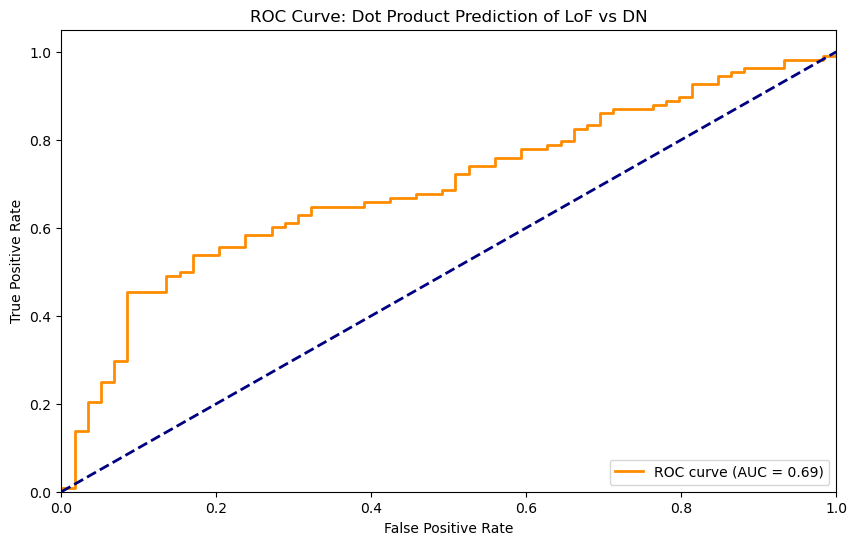

In [23]:
# Filter for only the two classes we want to compare
test_subset = test_df[test_df["category"].isin(["Only DN", "Only LoF"])]

# Create binary labels (1 for LoF, 0 for DN)
y_true = (test_subset["category"] == "Only LoF").astype(int)
y_scores = test_subset["dot_product"]

# Calculate and plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Dot Product Prediction of LoF vs DN')
plt.legend(loc="lower right")
plt.show()

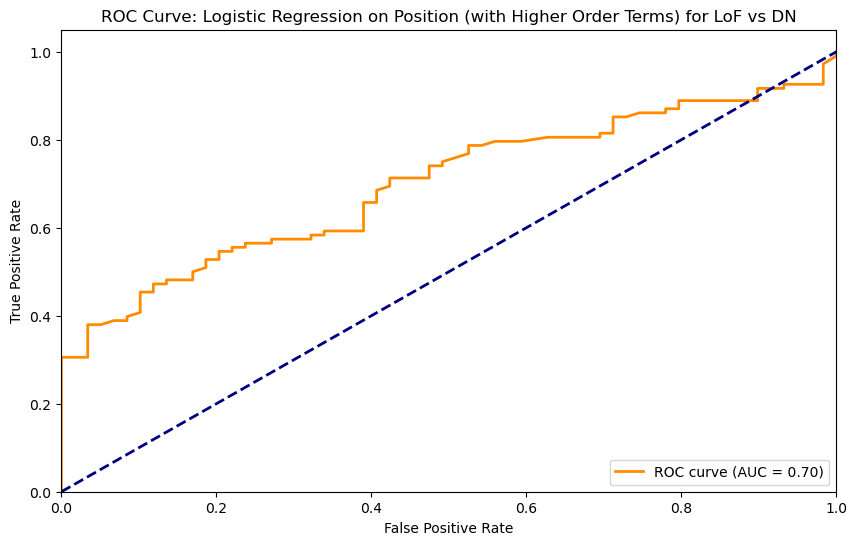

In [28]:
# Filter for only the two classes we want to compare for training
train_subset = train_df[train_df["category"].isin(["Only DN", "Only LoF"])]

# Create training data with higher order terms
pos = train_subset[["Pos"]].values
X_train = np.column_stack([
    pos,  # Linear term
    pos**2,  # Quadratic term 
    pos**3,  # Cubic term
    np.sin(pos/100),  # Sinusoidal term
    np.cos(pos/100)  # Cosine term
])
y_train = (train_subset["category"] == "Only LoF").astype(int)

# Train a logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# Filter test data
test_subset = test_df[test_df["category"].isin(["Only DN", "Only LoF"])]

# Create test data with same higher order terms
pos_test = test_subset[["Pos"]].values
X_test = np.column_stack([
    pos_test,
    pos_test**2,
    pos_test**3, 
    np.sin(pos_test/100),
    np.cos(pos_test/100)
])
y_true = (test_subset["category"] == "Only LoF").astype(int)

# Get prediction probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate and plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression on Position (with Higher Order Terms) for LoF vs DN')
plt.legend(loc="lower right")
plt.show()

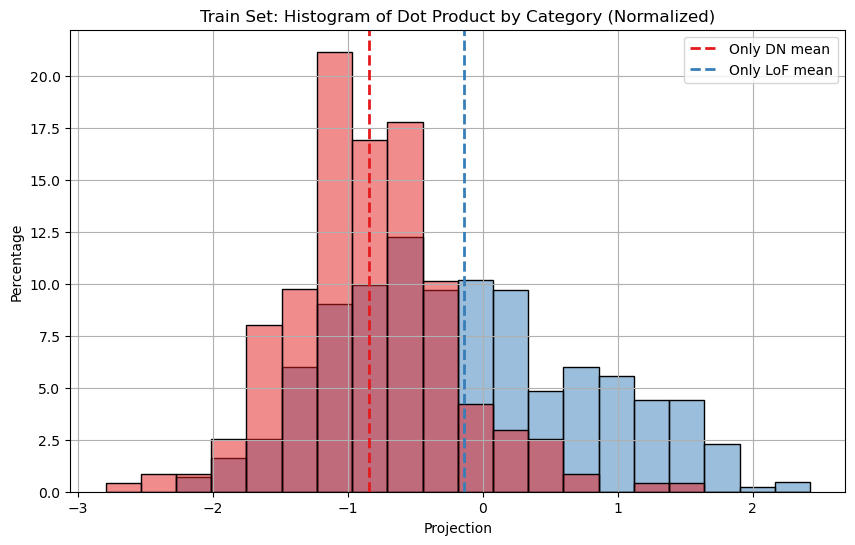

In [23]:

# pick nice colors from a seaborn palette
colors = sns.color_palette("Set1", n_colors=4)
palette = {"Only DN": colors[0], "Only LoF": colors[1], "DN & LoF": colors[2], "Others": colors[3]}

# filter data
subset = train_df[train_df["category"].isin(["Only DN", "Only LoF"])]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product",
    hue="category",
    palette=palette,
    stat="percent",    
    common_norm=False  
)

# compute and plot mean for each category
for cat in ["Only DN", "Only LoF"]:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Train Set: Histogram of Dot Product by Category (Normalized)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()

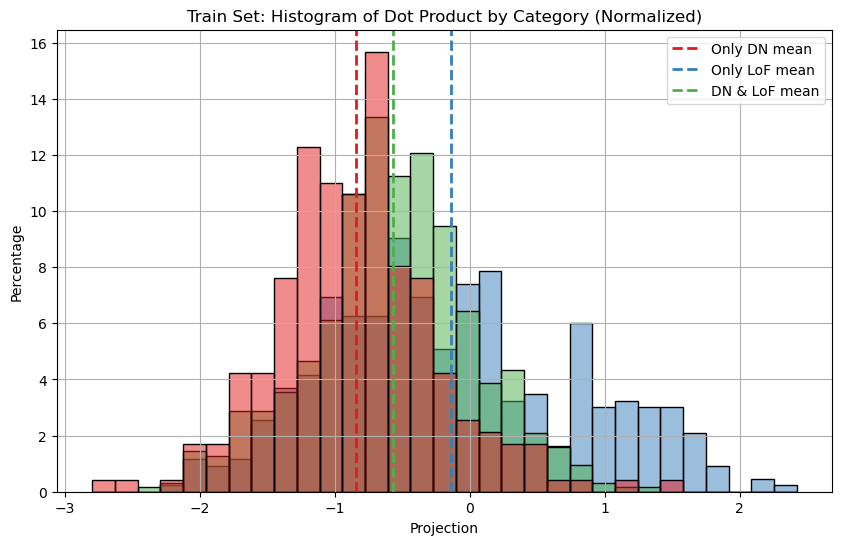

In [24]:
# filter data
filter = ["Only DN", "Only LoF", "DN & LoF"]
subset = train_df[train_df["category"].isin(filter)]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product",
    hue="category",
    palette=palette,
    stat="percent",    
    common_norm=False  
)

# compute and plot mean for each category
for cat in filter:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Train Set: Histogram of Dot Product by Category (Normalized)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()

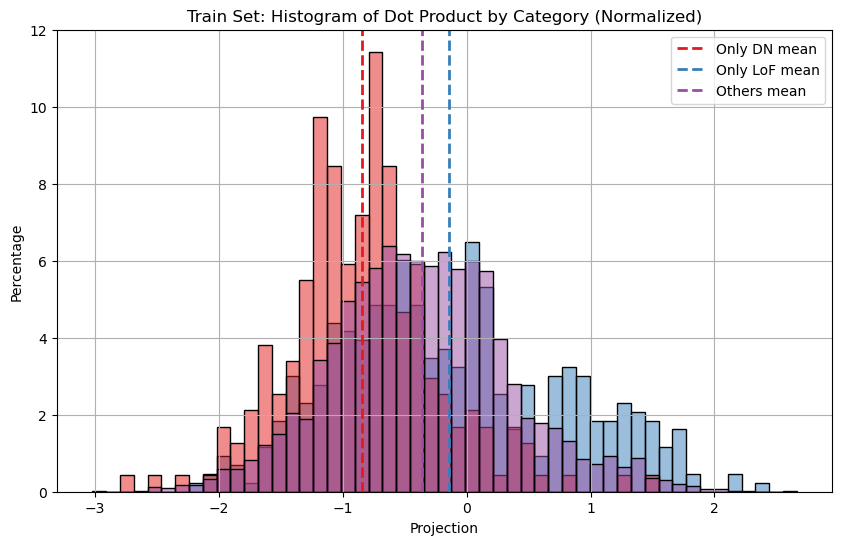

In [25]:
# filter data
filter = ["Only DN", "Only LoF", "Others"]# filter data
subset = train_df[train_df["category"].isin(filter)]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product",
    hue="category",
    palette=palette,
    stat="percent",    
    common_norm=False  
)

# compute and plot mean for each category
for cat in filter:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Train Set: Histogram of Dot Product by Category (Normalized)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()

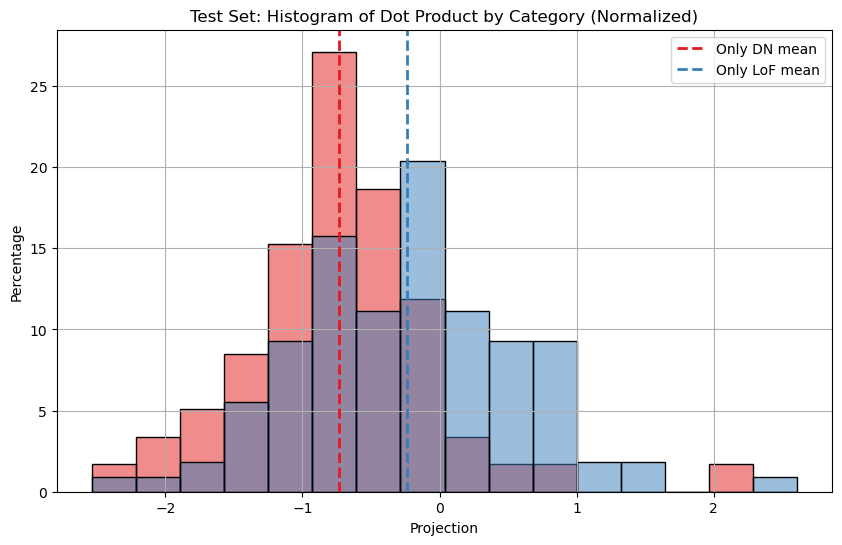

In [26]:
# filter data
filter = ["Only DN", "Only LoF"]# filter data
subset = test_df[test_df["category"].isin(filter)]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product",
    hue="category",
    palette=palette,
    stat="percent",    
    common_norm=False  
)

# compute and plot mean for each category
for cat in filter:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Test Set: Histogram of Dot Product by Category (Normalized)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()

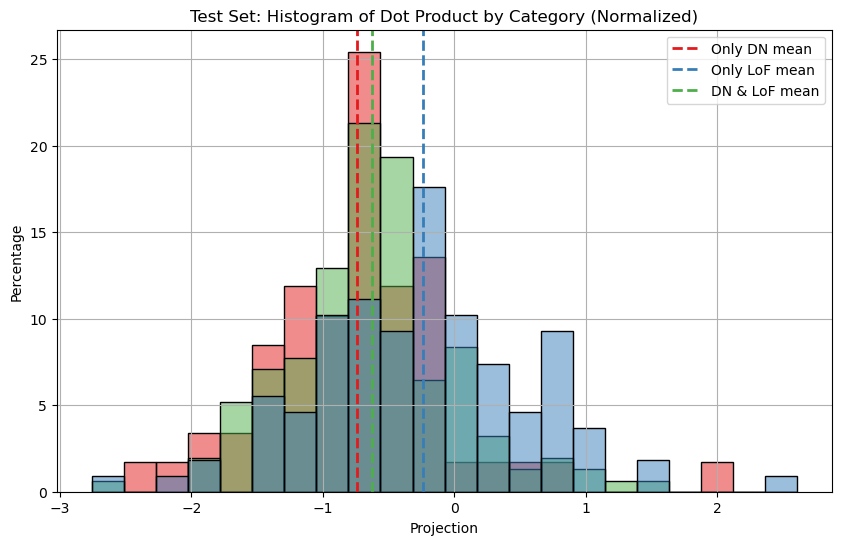

In [27]:
filter = ["Only DN", "Only LoF", "DN & LoF"]
subset = test_df[test_df["category"].isin(filter)]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product",
    hue="category",
    palette=palette,
    stat="percent",    
    common_norm=False  
)

# compute and plot mean for each category
for cat in filter:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Test Set: Histogram of Dot Product by Category (Normalized)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()

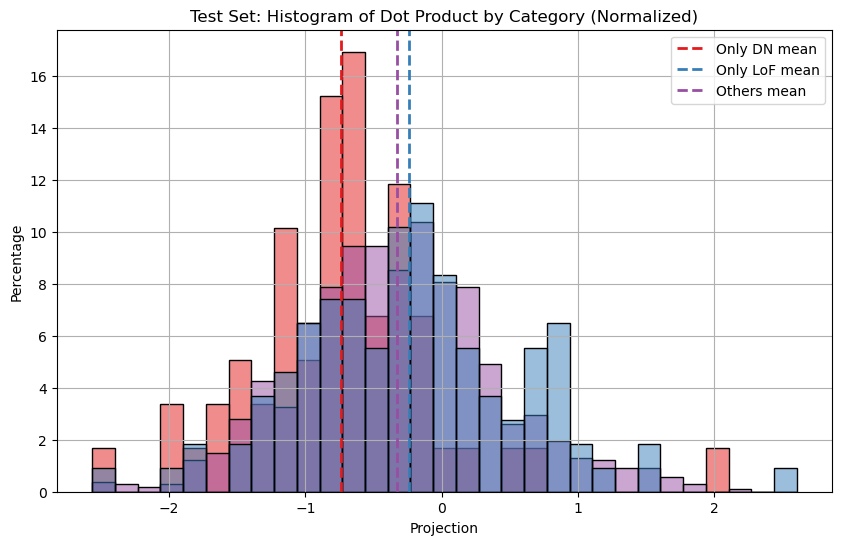

In [28]:
filter = ["Only DN", "Only LoF", "Others"]
subset = test_df[test_df["category"].isin(filter)]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product",
    hue="category",
    palette=palette,
    stat="percent",    
    common_norm=False  
)

# compute and plot mean for each category
for cat in filter:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Test Set: Histogram of Dot Product by Category (Normalized)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()

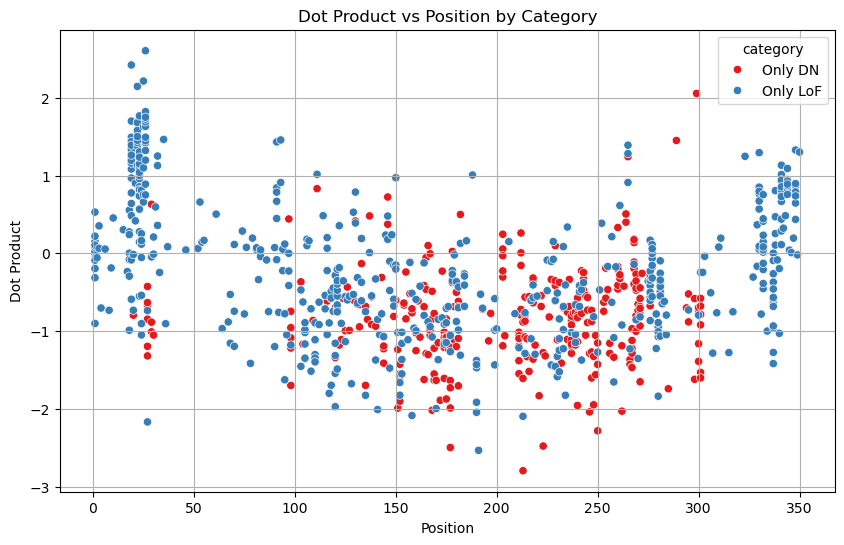

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df[df["category"].isin(["Only DN", "Only LoF"])],
    x="Pos", 
    y="dot_product",
    hue="category",
    palette=palette
)
plt.title("Dot Product vs Position by Category")
plt.xlabel("Position")
plt.ylabel("Dot Product")
plt.grid(True)
plt.show()

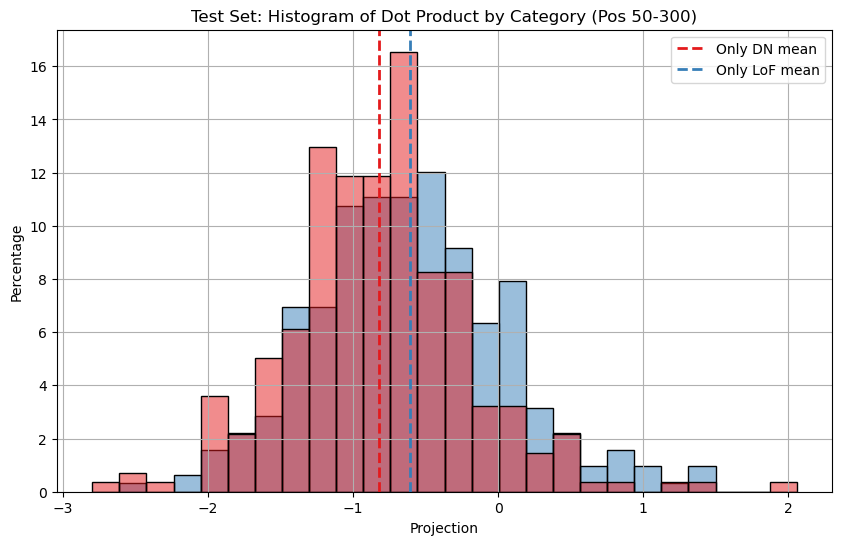

In [30]:
# Filter for Only DN and Only LoF, and positions between 50-300
filter = ["Only DN", "Only LoF"]
subset = df[df["category"].isin(filter)]
subset = subset[(subset["Pos"] >= 50) & (subset["Pos"] <= 300)]

# plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="dot_product", 
    hue="category",
    palette=palette,
    stat="percent",
    common_norm=False
)

# compute and plot mean for each category
for cat in filter:
    mean_val = subset[subset["category"] == cat]["dot_product"].mean()
    plt.axvline(mean_val, color=palette[cat], linestyle="--", linewidth=2, label=f"{cat} mean")

plt.title("Test Set: Histogram of Dot Product by Category (Pos 50-300)")
plt.xlabel("Projection")
plt.ylabel("Percentage")
plt.grid(True)
plt.legend()
plt.show()


In [31]:
# Perform t-test between Only DN and Only LoF dot products
dn_dots = subset[subset["category"] == "Only DN"]["dot_product"]
lof_dots = subset[subset["category"] == "Only LoF"]["dot_product"]

from scipy import stats
t_stat, p_value = stats.ttest_ind(dn_dots, lof_dots)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print("\nMeans:")
print(f"Only DN: {dn_dots.mean():.4f}")
print(f"Only LoF: {lof_dots.mean():.4f}")


T-statistic: -3.9754
P-value: 0.0001

Means:
Only DN: -0.8199
Only LoF: -0.6056
